In [1]:
import numpy as np
import obspy
from hydrophone_data_processing import load, useful_variables, plotting, signal_processing
import scipy.signal as signal
import pandas as pd
import matplotlib.dates as dates
import obspy.signal.trigger as trigger
import matplotlib.pyplot as plt

def import_data(day, starttime, endtime):
    daypaths = useful_variables.make_hydrophone_data_paths(borehole='a', year=2019, julian_day=day)
    starttime = obspy.UTCDateTime(starttime)
    endtime = obspy.UTCDateTime(endtime)
    data = load.import_corrected_data_for_single_day(daypaths)
    data.trim(starttime=starttime, endtime=endtime)
    return data

# day188_paths = useful_variables.make_hydrophone_data_paths(borehole='a', year=2019, julian_day=188)
# day188 = load.import_corrected_data_for_single_day(day188_paths)
# starttime = obspy.UTCDateTime('2019-07-07T08:00:00')
# endtime = obspy.UTCDateTime('2019-07-07T11:00:00')
# day188.trim(starttime=starttime, endtime=endtime)

In [2]:
day141 = import_data(day=141, starttime='2019-05-21T07:00:00.0Z', endtime='2019-05-21T09:00:00.0Z')

In [3]:
day188 = import_data(day=188, starttime='2019-07-07T08:40:00.0Z', endtime='2019-07-07T10:15:00.0Z')

In [4]:
day197 = import_data(day=197, starttime='2019-07-16T21:45:00.0Z', endtime='2019-07-17T00:00:00.337999Z')

In [5]:
day211 = import_data(day=211, starttime='2019-07-30T22:30:05.142999Z', endtime='2019-07-30T23:07:04.430999Z')

In [6]:
day141[0].stats

         network: 7F
         station: A00
        location: 01
         channel: GDH
       starttime: 2019-05-21T07:00:00.000000Z
         endtime: 2019-05-21T09:00:00.000000Z
   sampling_rate: 1000.0
           delta: 0.001
            npts: 7200001
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 14851, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 4096, 'filesize': 60829696})
      processing: ['ObsPy 1.3.0: trim(endtime=UTCDateTime(2019, 5, 21, 9, 0)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2019, 5, 21, 7, 0))']

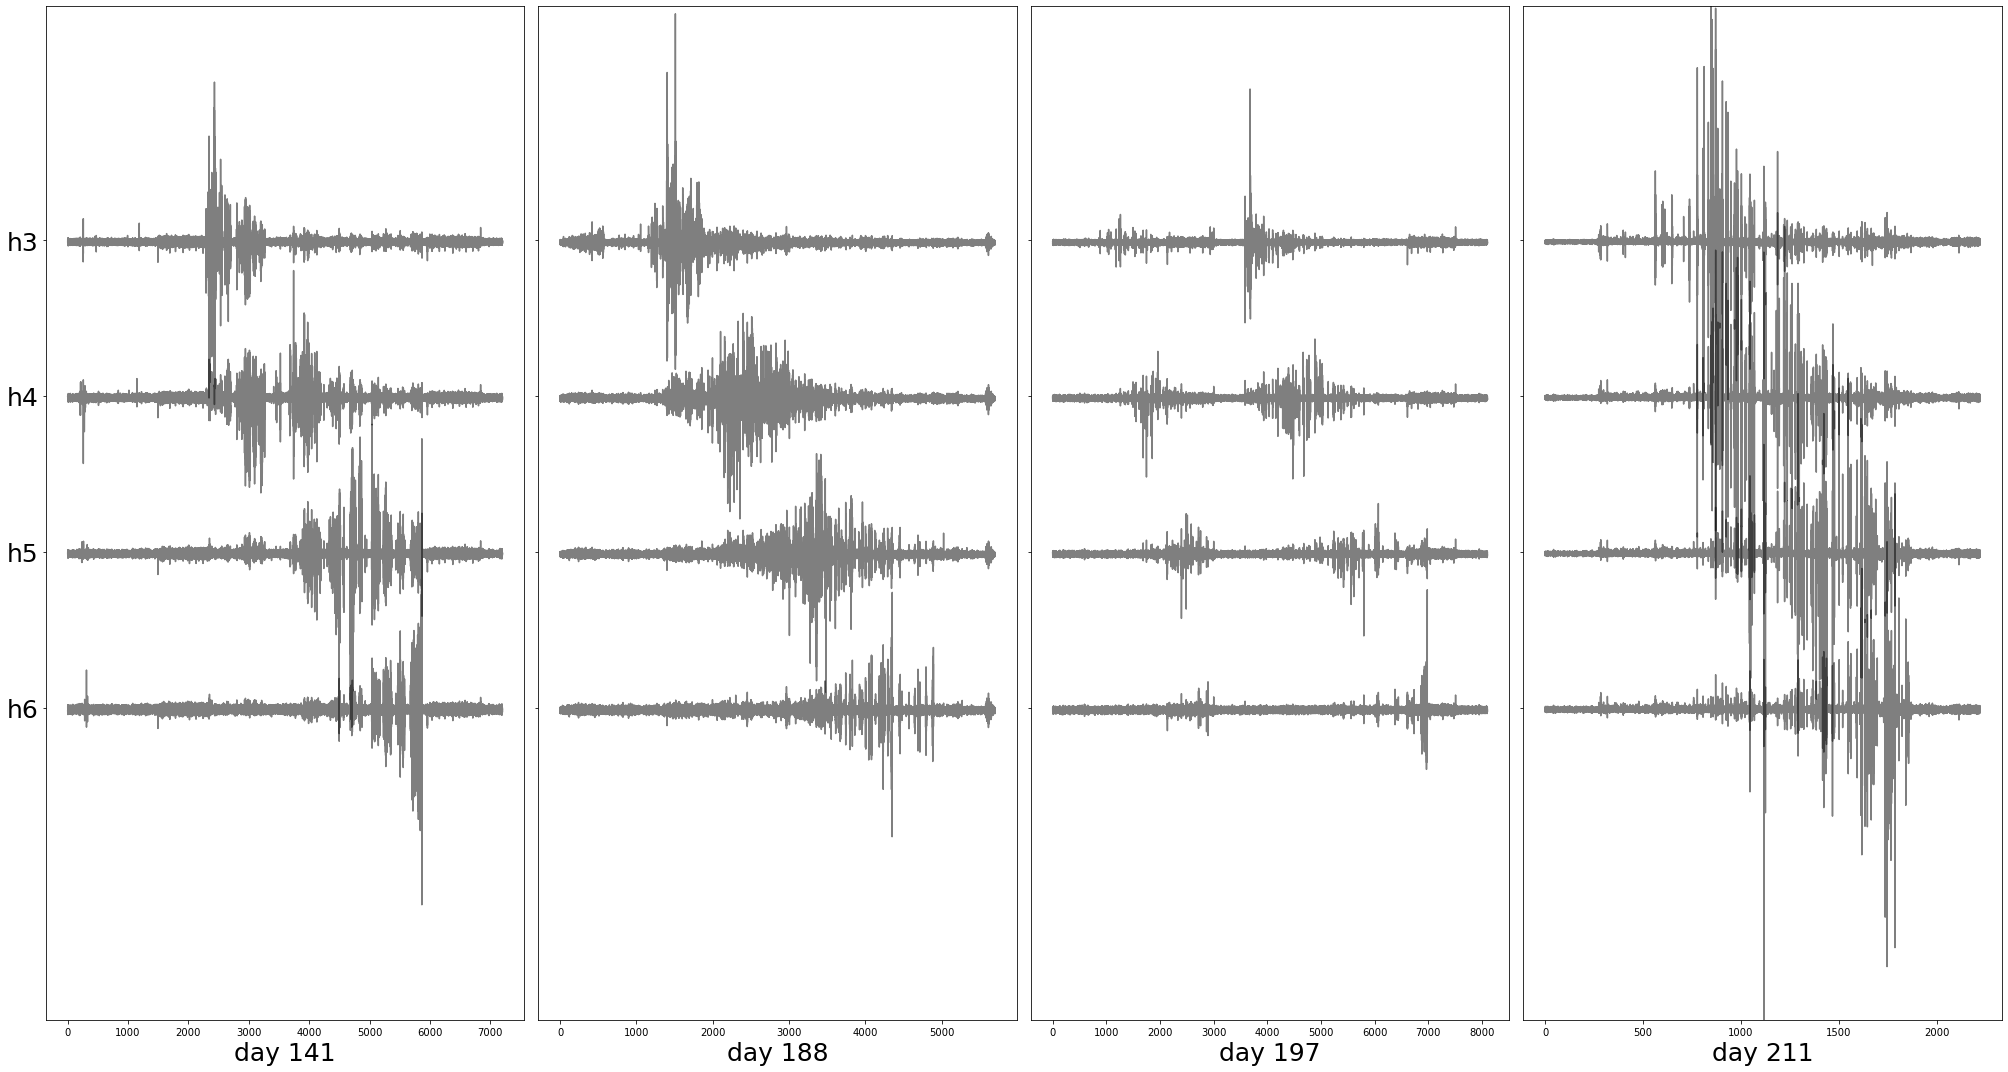

In [7]:
fig, ax = plt.subplots(1, 4, figsize=(7*4, 15), sharey=True)

def plot_waveform(ax, stream, day):
    # times = [tr.times('matplotlib') for tr in stream][2:]
    times = [tr.times() for tr in stream][2:]
    data = [tr.data for tr in stream][2:]
    n = 0
    for t, d in zip(times, data):
        ax.plot(t, d - n * 10, color='black', alpha=0.5)
        n+=1
        
    ax.set_xlabel('day ' + str(day), fontsize=25)

plot_waveform(ax=ax[0], stream=day141, day=141)
plot_waveform(ax=ax[1], stream=day188, day=188)
plot_waveform(ax=ax[2], stream=day197, day=197)
plot_waveform(ax=ax[3], stream=day211, day=211)

ax[0].set_ylim(-50, 15)
ax[0].set_yticks([0, -10, -20, -30])
ax[0].set_yticklabels(['h3', 'h4', 'h5', 'h6'], fontsize=25)

# ax[0].text(s='day')

plt.tight_layout()

In [8]:
import matplotlib.dates as dates

def import_catalog(file):
    df = pd.read_csv(file)
    df.sort_values(by='first_arrival', inplace=True)
    df['arrival_datetime'] = df.arrival_time.apply(dates.num2date)
    return df

def plot_depths(df, cmap, day):
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.scatter(df.arrival_datetime, df.depth, marker='.', linewidth=0, c=df.first_hydrophone, cmap=cmap)
    ax.set_ylabel('day '+str(day), fontsize=25)
    ax.set_ylim(400, 50)
    ax.text(s='N_events={}'.format(df.shape[0]), x=df.arrival_time[50], y=375, fontsize=25)
    return fig, ax

def plot_radius(df, cmap, day):
    x = df.first_arrival.values
    y = np.abs(df.radius.values)
    c = df.depth.values
    
    fig, ax = plt.subplots(figsize=(15, 5))
    cbar = ax.scatter(x, y, marker='.', c=c, vmin=150, vmax=400, cmap=cmap)
    ax.set_xticks([])
    ax.set_ylim(-10, 60)
    fig.colorbar(cbar, label='depth (m)')
    ax.set_xlabel('time ---->', fontsize=15)
    ax.set_ylabel('radius (m)', fontsize=15)
    return fig, ax

In [9]:
df141 = import_catalog(file='precision.csv')
df188 = import_catalog(file='188precision.csv')
df197 = import_catalog(file='197precision.csv')
df211 = import_catalog(file='211precision.csv')

(<Figure size 1080x360 with 1 Axes>, <AxesSubplot:ylabel='day 211'>)

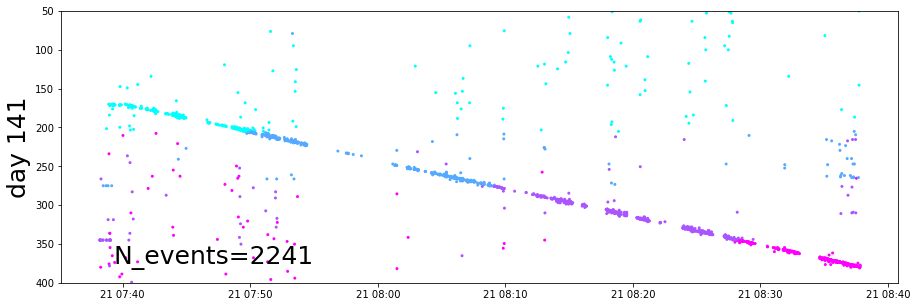

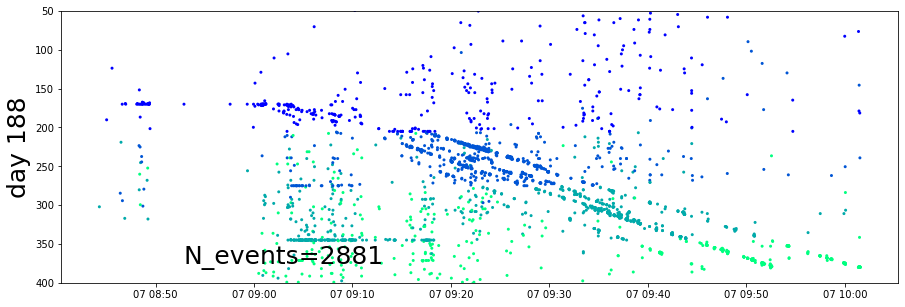

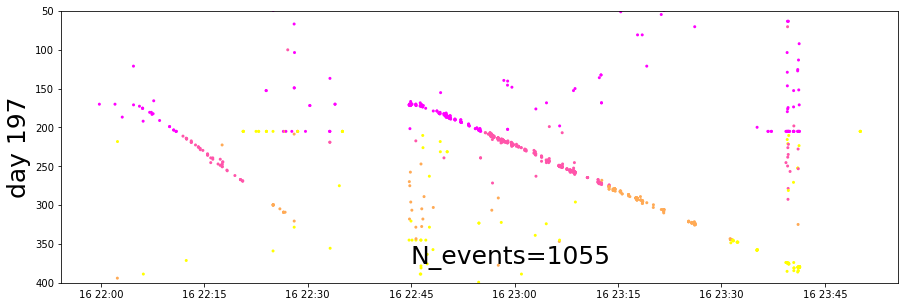

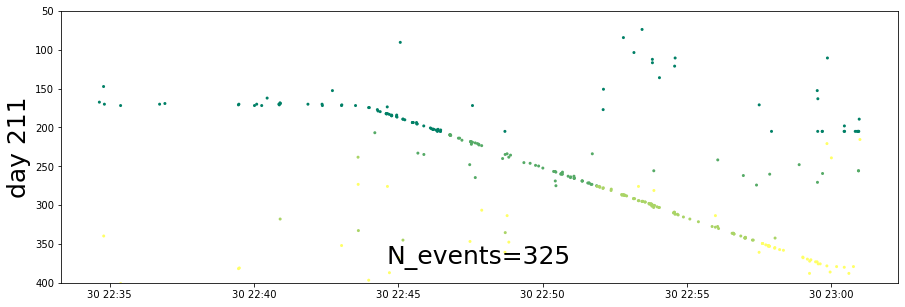

In [10]:
plot_depths(df=df141, cmap='cool', day=141)
plot_depths(df=df188, cmap='winter', day=188)
plot_depths(df=df197, cmap='spring', day=197)
plot_depths(df=df211, cmap='summer', day=211)

In [100]:
df141.arrival_time - 18037.318172

0       2.337983e-07
1       1.553472e-05
2       2.942361e-05
3       4.528009e-05
4       4.852083e-05
            ...     
2236    4.139151e-02
2237    4.139845e-02
2238    4.140622e-02
2239    4.141726e-02
2240    4.142712e-02
Name: arrival_time, Length: 2241, dtype: float64

Intercept:  -43090505.5420904
Coefficient:  [2388.97611556]
R^2 score:  -8.60140211809147


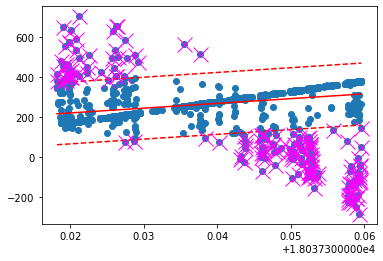

In [106]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# input data
# X = np.array([[1], [2], [3], [4], [5]])
# y = np.array([1, 2, 3, 4, 5])
y = df141.depth.values
X = (df141.arrival_time).values.reshape(-1, 1)
index = df141.index
# create and fit the model
model = LinearRegression().fit(X, y)

# make predictions
predictions = model.predict(X)

# check the coefficients
print("Intercept: ", model.intercept_)
print("Coefficient: ", model.coef_)

# check the R^2 score
# print("R^2 score: ", model.score(X, y))
print("R^2 score: ", r2_score(y_true=predictions, y_pred=y))

fig, ax = plt.subplots()
ax.scatter(X, y)

modx = np.linspace(X.min(), X.max(), 2241)
mody = model.intercept_ + model.coef_*modx
ax.plot(modx, mody, color='red')

removal_factor = 5 * np.std(predictions)
removal_positive = mody + removal_factor
removal_negative = mody - removal_factor

removal_index = np.hstack(
    (np.where(y > removal_positive)
     ,np.where(y < removal_negative)
    ))
# for some reason this creates an array inside the array hence the [0]
y_removal = y[removal_index][0]
X_removal = X.flatten()[removal_index][0]

ax.plot(modx, removal_positive, color='red', linestyle='--')
ax.plot(modx, removal_negative, color='red', linestyle='--')

ax.plot(X_removal, y_removal, marker='x', color='magenta', markersize=15, linewidth=0)


R2: 0.49987825641195904


ValueError: operands could not be broadcast together with shapes (2241,) (2137,) 

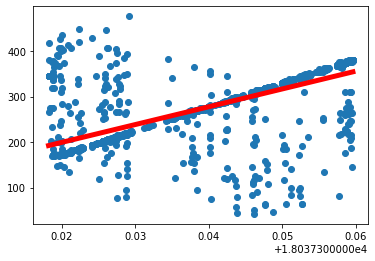

In [158]:
X.flatten()[~removal_index][0]

X_flat = X.flatten()
X_new = np.delete(X_flat, removal_index).reshape(-1, 1)
y_new = np.delete(y, removal_index)

model_new = LinearRegression().fit(X_new, y_new)
preds_new = model_new.predict(X_new)
print('R2:', r2_score(y_new, preds_new))

fig, ax = plt.subplots()

ax.scatter(X_new, y_new)

modx_new = np.linspace(X_new.min(), X_new.max(), y_new.shape[0]).reshape(-1, 1)
mody_new = model_new.predict(modx_new)
ax.plot(modx_new, mody_new, color='red', linewidth=5)


#############


removal_factor = 5 * np.std(preds_new)
removal_positive = mody_new + removal_factor
removal_negative = mody_new - removal_factor

removal_index = np.hstack(
    (np.where(y > removal_positive)
     ,np.where(y < removal_negative)
    ))
# for some reason this creates an array inside the array hence the [0]
y_removal = y_new[removal_index][0]
X_removal = X_new.flatten()[removal_index][0]

ax.plot(modx_new, removal_positive, color='red', linestyle='--')
ax.plot(modx_new, removal_negative, color='red', linestyle='--')

ax.plot(X_removal, y_removal, marker='x', color='magenta', markersize=15, linewidth=0)


In [182]:
# blah = np.array([[1, 2, 3, 4]])
# blah.reshape(-1, 1).reshape(-1, 1)

array([[1],
       [2],
       [3],
       [4]])

In [191]:
def remove_data_using_linear_model(X, y, removal_factor):
    
    # just in case
    # X = X.reshape(-1, 1)
    
    model = LinearRegression().fit(X, y)
    predictions = model.predict(X)
    
    removal_index = np.hstack(
        (np.where(y > predictions + removal_factor*np.std(predictions))
        ,np.where(y < predictions - removal_factor*np.std(predictions)))
    )
    X_new = np.delete(X, removal_index)
    y_new = np.delete(y, removal_index)
    
    return X_new, y_new, model

In [201]:
xnew, ynew, mod = remove_data_using_linear_model(X=X, y=y, removal_factor=5)
print('iteration 1:', r2_score(y, mod.predict(X)))

xnew, ynew, mod = remove_data_using_linear_model(X=xnew.reshape(-1, 1), y=ynew, removal_factor=5)
print('iteration 2:', r2_score(ynew, mod.predict(xnew.reshape(-1, 1))))

# print('iteration 1: ',r2_score(y, mod.predict(X.reshape(-1, 1)))

# xnew, ynew, mod = remove_data_using_linear_model(X=xnew, y=ynew, removal_factor=5)
# print('iteration 2: ',r2_score(ynew, mod.predict(xnew)))

iteration 1: 0.0943271454908785
iteration 2: 0.7031697999299873


In [190]:
# # def fit_linear_model(X, y):
# #     model = LinearRegression().fit(X, y)
# #     predictions = model.predict(X)
    
# #     modx = np.linspace(X.min(), X.max(), y.shape[0])
# #     mody = 


# def remove_badData(X, y, removal_factor, r2_threshold):
#     """
#     X : time index
#     y : depths
#     removal_factor : multiplier for standard deviation sigma
#     r2_threshold : r2 score to exit while loop when model is good enough
    
#     """
#     iteration = 0
#     R2 = -9999
    
#     while R2 < r2_threshold:
#         # TODO : fit linear regression model to X and y
#         # modx, mody, model = fit_linear_model(X, y)
#         model = LinearRegression().fit(X, y)
#         predictions = model.predict(X)
#         R2 = r2_score(y, predictions)
        
#         if R2 < r2_threshold:
#             pass
#         else:
            
#         # TODO : put 

# #         if r2_score(y, mody) > r2_threshold:
# #             return X, y
# #         else:
# #             remove_badData(X=new)
#         # TODO : remove values based on sigma removal factor multiplier
#         # TODO : refit linear regression model to new_X and new_y
#         # TODO : remove values based on new sigma removal factor multiplier
#         # TODO : End when R2 > something

SyntaxError: unexpected EOF while parsing (935197680.py, line 40)

(<Figure size 1080x360 with 2 Axes>,
 <AxesSubplot:xlabel='time ---->', ylabel='radius (m)'>)

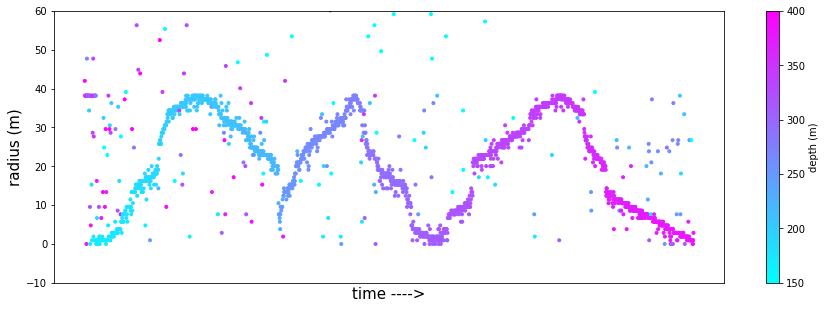

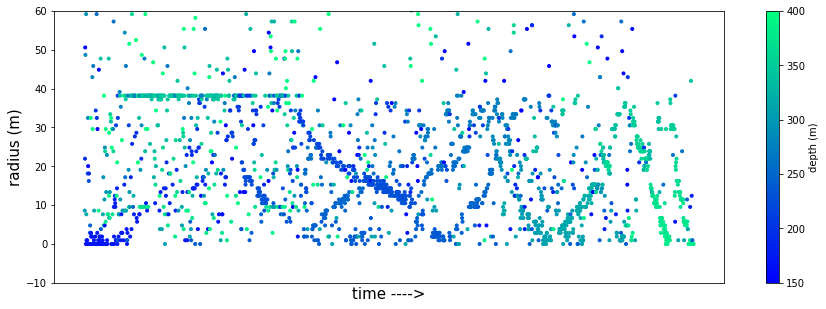

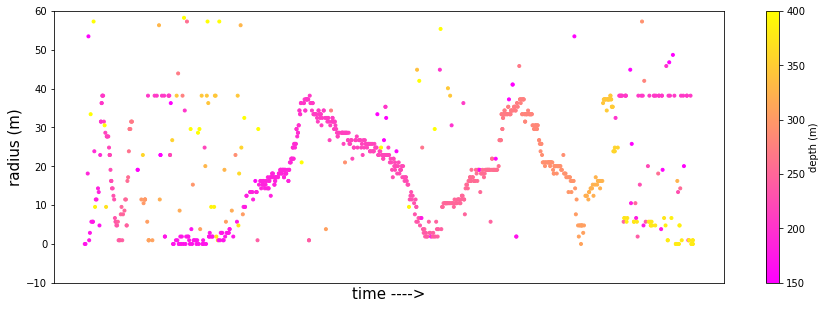

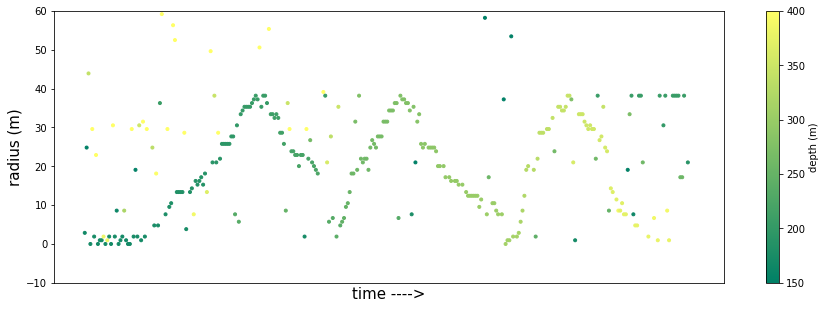

In [77]:
plot_radius(df=df141, cmap='cool', day=141)
plot_radius(df=df188, cmap='winter', day=188)
plot_radius(df=df197, cmap='spring', day=197)
plot_radius(df=df211, cmap='summer', day=211)

In [78]:
# fig, ax = plt.subplots(figsize=(15, 5))
# # df.set_index('arrival_datetime').depth.plot(ax=ax, linewidth=0, marker='.', color='limegreen')

# ax.scatter(df141.arrival_datetime, df141.depth, marker='.', linewidth=0, c=df141.first_hydrophone, cmap='cool')

# ax.set_ylim(400, 50)

In [47]:
# import matplotlib.dates as dates
# df188 = pd.read_csv('188precision.csv')
# df188.sort_values(by='first_arrival', inplace=True)
# df188['arrival_datetime'] = df188.arrival_time.apply(dates.num2date)

(400.0, 50.0)

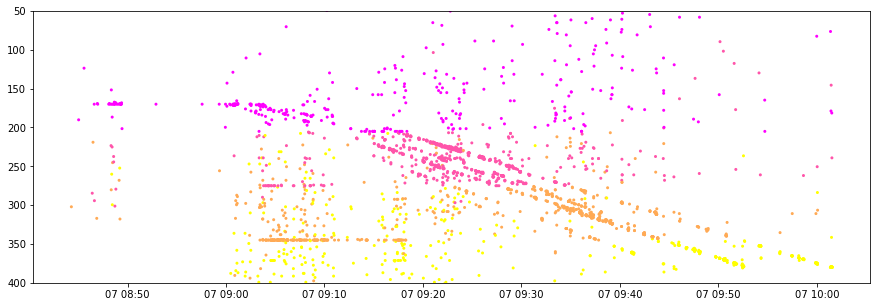

In [48]:
# fig, ax = plt.subplots(figsize=(15, 5))
# # df.set_index('arrival_datetime').depth.plot(ax=ax, linewidth=0, marker='.', color='limegreen')

# ax.scatter(df188.arrival_datetime, df188.depth, marker='.', linewidth=0, c=df188.first_hydrophone, cmap='warm')

# ax.set_ylim(400, 50)